In [1]:
import pandas as pd
import numpy as np
import modules.analysis as analysis
import modules.utils as utils

# TS decomposition analysis
## Create metric CSV

In [5]:
df = analysis.eval_metrics('2022110813610413', out_path='analysis/benchmark/', min_months=24)

Experiment experiments/2022110813610413_4 couln't be loaded.
Experiment experiments/2022110813610413_12 couln't be loaded.


## Plot benchmark charts

In [2]:
exp_ids = [2022102313544246, 2022102313544325, 2022110413591325, 2022110813610319, 
           2022110213583060, 2022110213583128, 2022110413591387, 2022110813610380,
           2022102513552709, 2022102513552801, 2022110313584614, 2022110813610397,
           2022103113574994, 2022103113574896, 2022110413591449, 2022110813610413]
var_sets = ['RS minimal', 'RS minimal', 'RS minimal', 'RS minimal', 
            'RS minimal +VI', 'RS minimal +VI', 'RS minimal +VI', 'RS minimal +VI', 
            'RS', 'RS', 'RS', 'RS', 
            'RS meteo', 'RS meteo', 'RS meteo', 'RS meteo']
frameworks = ['Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon', 
              'Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon', 
              'Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon',
              'Random Forest', 'H2O AutoML', 'AutoSklearn', 'AutoGluon',]

frames =[]
for idx, exp_id in enumerate(exp_ids):
    df = pd.read_csv('analysis/benchmark/' + str(exp_id) + '/metrics.csv')
    df['Explanatory variable set'] = var_sets[idx]
    df['Framework'] = frameworks[idx]
    frames.append(df)
    
df = pd.concat(frames)

In [3]:
df500 = pd.read_csv('analysis/benchmark/2022110313584310/metrics.csv')

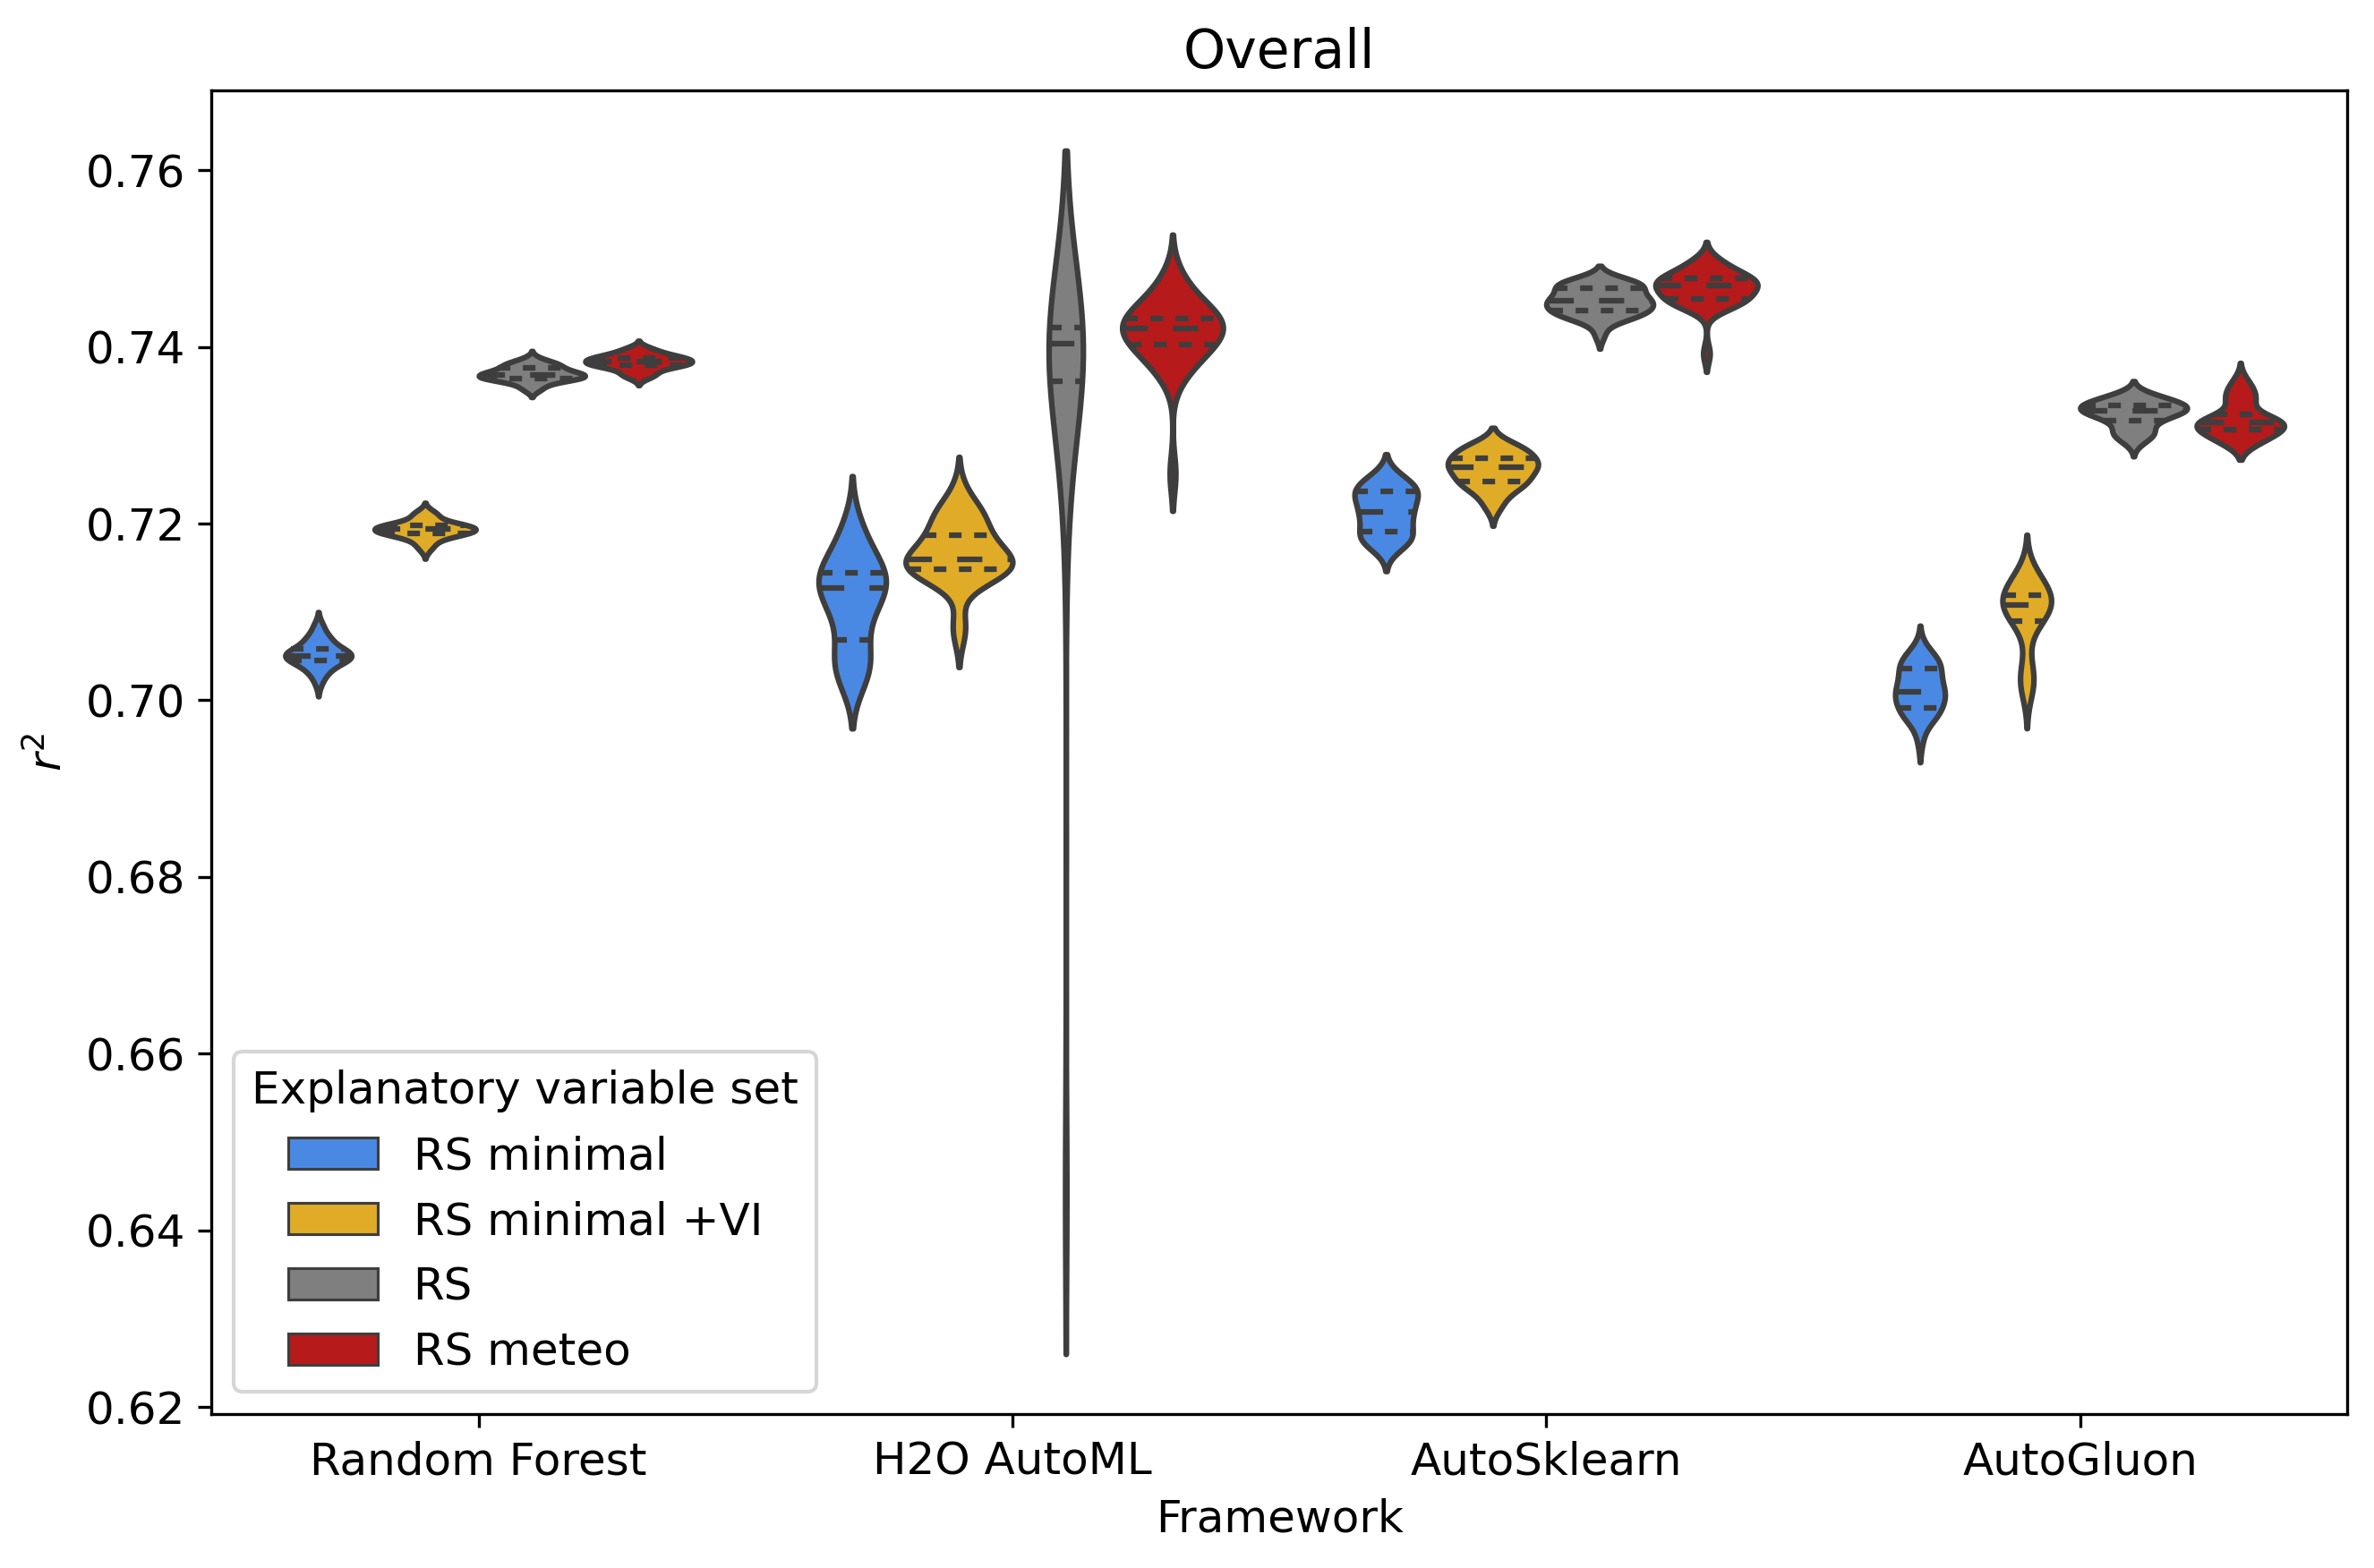

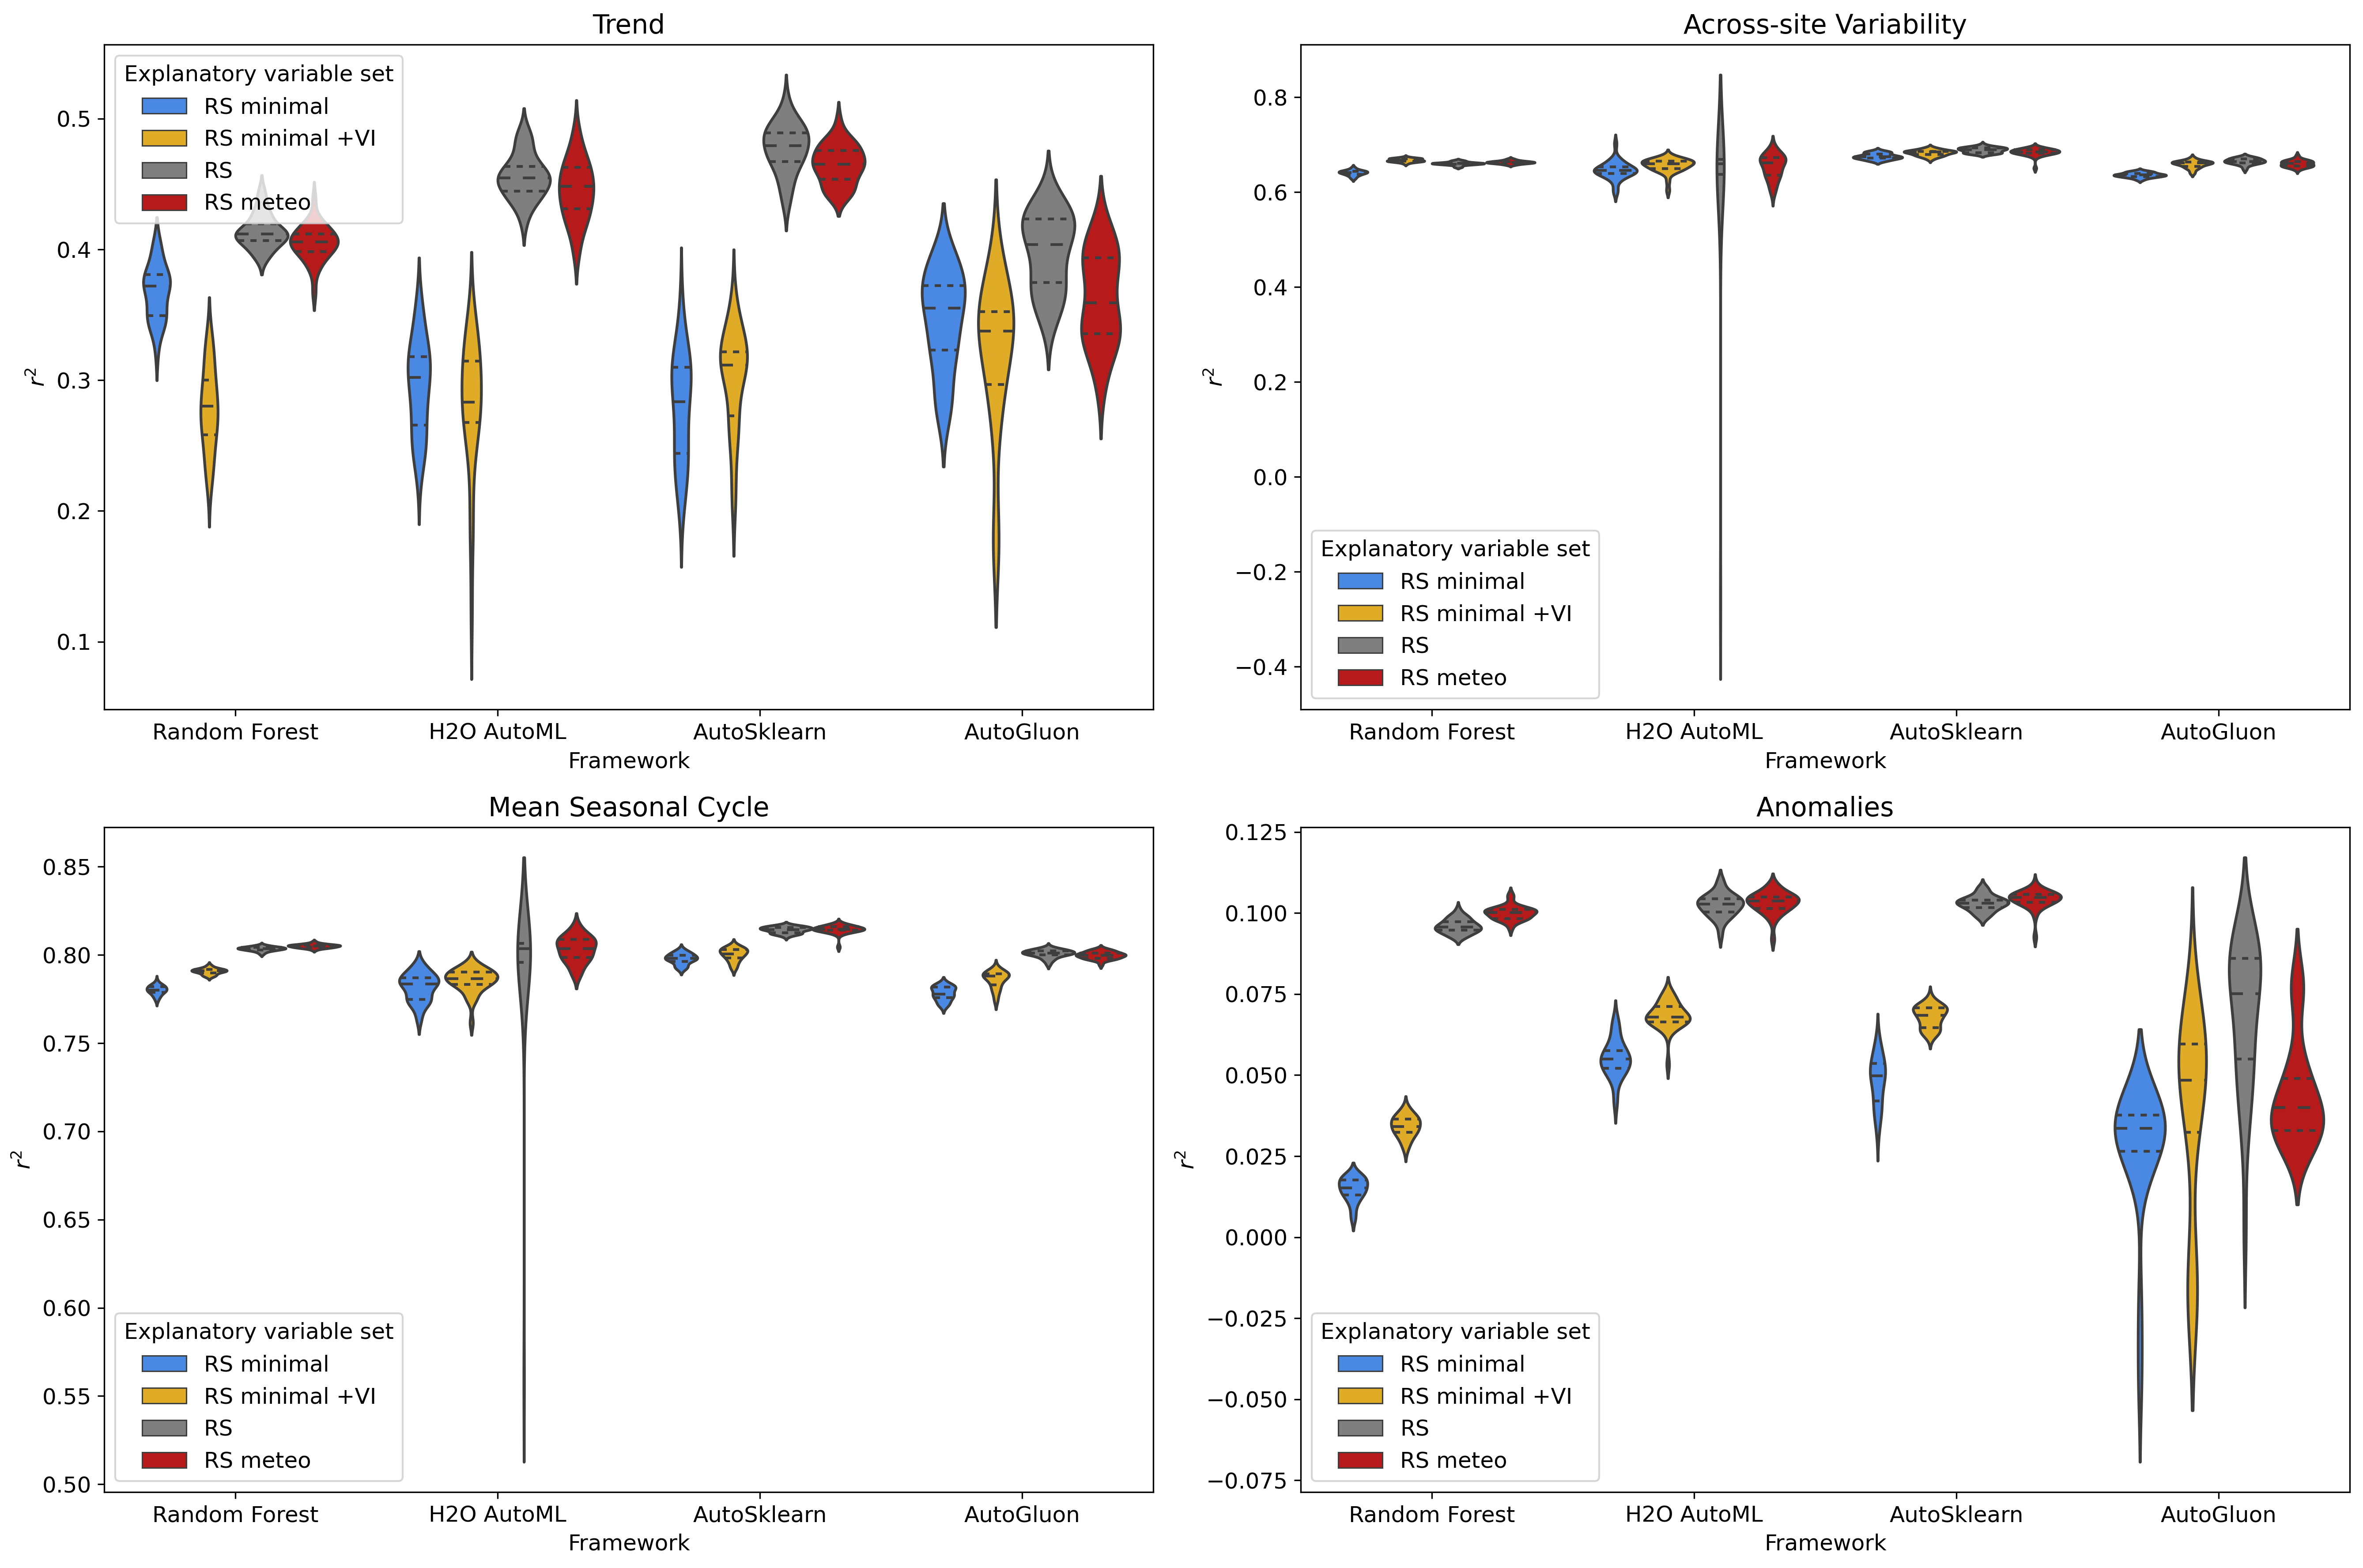

In [6]:
analysis.plt_model_comparison(df, 'analysis/benchmark/', 'Explanatory variable set', 'Framework', 'r2_overall')

In [4]:
# Metrics
df.groupby(['Framework', 'Explanatory variable set']).mean()

/tmp/ipykernel_186/3503398917.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['Framework', 'Explanatory variable set']).mean()


r2_overall  r2_trend  r2_anomalies  \
Framework     Explanatory variable set                                       
AutoGluon     RS                          0.732416  0.398281      0.068313   
              RS meteo                    0.731773  0.362325      0.043870   
              RS minimal                  0.701308  0.345597      0.026747   
              RS minimal +VI              0.709655  0.319889      0.037552   
AutoSklearn   RS                          0.745202  0.477413      0.103077   
              RS meteo                    0.746581  0.464917      0.104210   
              RS minimal                  0.721410  0.278891      0.048244   
              RS minimal +VI              0.726082  0.301064      0.068003   
H2O AutoML    RS                          0.735369  0.455500      0.102501   
              RS meteo                    0.741576  0.444822      0.103198   
              RS minimal                  0.711214  0.295208      0.055044   
              RS minimal +VI              0.716639  0.280111      0.068353   
Random Forest RS                          0.736942  0.413648      0.096008   
              RS meteo                    0.738279  0.404736      0.100064   
              RS minimal                  0.705215  0.367369      0.014700   
              RS minimal +VI              0.719338  0.277841      0.034191   

                                        r2_sites    r2_msc  rmse_overall  \
Framework     Explanatory variable set                                     
AutoGluon     RS                        0.664953  0.800695      1.984148   
              RS meteo                  0.660072  0.799796      1.986526   
              RS minimal                0.636158  0.778099      2.096417   
              RS minimal +VI            0.658935  0.785791      2.066893   
AutoSklearn   RS                        0.688638  0.814157      1.936164   
              RS meteo                  0.684148  0.814452      1.930908   
              RS minimal                0.675457  0.797806      2.024645   
              RS minimal +VI            0.682727  0.800177      2.007604   
H2O AutoML    RS                        0.618637  0.792295      1.972211   
              RS meteo                  0.653530  0.803163      1.949839   
              RS minimal                0.645589  0.781689      2.061302   
              RS minimal +VI            0.655868  0.785395      2.041886   
Random Forest RS                        0.660388  0.803474      1.987617   
              RS meteo                  0.663041  0.805020      1.982558   
              RS minimal                0.640792  0.780026      2.080443   
              RS minimal +VI            0.667435  0.790738      2.029603   

                                        rmse_trend  rmse_anomalies  \
Framework     Explanatory variable set                               
AutoGluon     RS                          0.017793        1.253644   
              RS meteo                    0.018315        1.271068   
              RS minimal                  0.018125        1.284427   
              RS minimal +VI              0.018469        1.276265   
AutoSklearn   RS                          0.016584        1.229074   
              RS meteo                    0.016782        1.228372   
              RS minimal                  0.019026        1.269062   
              RS minimal +VI              0.018732        1.255011   
H2O AutoML    RS                          0.016928        1.230465   
              RS meteo                    0.017092        1.229860   
              RS minimal                  0.018812        1.265242   
              RS minimal +VI              0.019007        1.255821   
Random Forest RS                          0.018804        1.243965   
              RS meteo                    0.018946        1.240835   
              RS minimal                  0.019013        1.277564   
              RS minimal +VI              0.022018        1.254482   

     

In [5]:
df.groupby(['Framework', 'Explanatory variable set']).agg(lambda x: 1.96 * x.std() / np.sqrt(x.count()))

/tmp/ipykernel_186/2619392988.py:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.agg is deprecated. In a future version, a TypeError will be raised. Before calling .agg, select only columns which should be valid for the function.
  df.groupby(['Framework', 'Explanatory variable set']).agg(lambda x: x.std() / np.sqrt(x.count()))


r2_overall  r2_trend  r2_anomalies  \
Framework     Explanatory variable set                                       
AutoGluon     RS                          0.000286  0.005726      0.004424   
              RS meteo                    0.000369  0.006738      0.002992   
              RS minimal                  0.000471  0.006816      0.003935   
              RS minimal +VI              0.000714  0.010726      0.005814   
AutoSklearn   RS                          0.000287  0.003452      0.000430   
              RS meteo                    0.000370  0.002704      0.000531   
              RS minimal                  0.000461  0.007558      0.001397   
              RS minimal +VI              0.000353  0.007031      0.000610   
H2O AutoML    RS                          0.003287  0.003101      0.000655   
              RS meteo                    0.000755  0.004180      0.000617   
              RS minimal                  0.000944  0.006494      0.001074   
              RS minimal +VI              0.000655  0.009297      0.000778   
Random Forest RS                          0.000156  0.002284      0.000396   
              RS meteo                    0.000154  0.002451      0.000389   
              RS minimal                  0.000269  0.003812      0.000674   
              RS minimal +VI              0.000178  0.005699      0.000604   

                                        r2_sites    r2_msc  rmse_overall  \
Framework     Explanatory variable set                                     
AutoGluon     RS                        0.001212  0.000432      0.001061   
              RS meteo                  0.001296  0.000386      0.001369   
              RS minimal                0.000891  0.000705      0.001653   
              RS minimal +VI            0.001376  0.000891      0.002531   
AutoSklearn   RS                        0.001019  0.000320      0.001089   
              RS meteo                  0.001468  0.000437      0.001407   
              RS minimal                0.001139  0.000549      0.001676   
              RS minimal +VI            0.001108  0.000660      0.001294   
H2O AutoML    RS                        0.030742  0.008244      0.011459   
              RS meteo                  0.004604  0.001325      0.002830   
              RS minimal                0.003447  0.001441      0.003366   
              RS minimal +VI            0.002693  0.001259      0.002359   
Random Forest RS                        0.000621  0.000216      0.000589   
              RS meteo                  0.000576  0.000186      0.000582   
              RS minimal                0.001010  0.000484      0.000950   
              RS minimal +VI            0.000636  0.000298      0.000644   

                                        rmse_trend  rmse_anomalies  \
Framework     Explanatory variable set                               
AutoGluon     RS                          0.000084        0.003073   
              RS meteo                    0.000097        0.002107   
              RS minimal                  0.000094        0.002595   
              RS minimal +VI              0.000142        0.003893   
AutoSklearn   RS                          0.000055        0.000304   
              RS meteo                    0.000042        0.000398   
              RS minimal                  0.000100        0.001020   
              RS minimal +VI              0.000093        0.000452   
H2O AutoML    RS                          0.000048        0.000518   
              RS meteo                    0.000064        0.000487   
              RS minimal                  0.000087        0.000745   
              RS minimal +VI              0.000120        0.000536   
Random Forest RS                          0.000037        0.000272   
              RS meteo                    0.000039        0.000263   
              RS minimal                  0.000057        0.000449   
              RS minimal +VI              0.000087        0.000391   

     

In [5]:
print(df.r2_overall.min(), df.r2_overall.max())

0.6442480954271068 0.7498220994871763


In [10]:
df500.mean()

exp_id                 inf
r2_overall        0.809033
r2_trend          0.531117
r2_anomalies      0.302461
r2_sites          0.760584
r2_msc            0.861739
rmse_overall      1.673963
rmse_trend        0.016146
rmse_anomalies    1.080491
rmse_sites        0.878120
rmse_msc          1.266565
dtype: float64

In [11]:
1.96 * df500.std() / np.sqrt(df500.count())

/tmp/ipykernel_178/2066647668.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  1.96 * df500.std() / np.sqrt(df500.count())


exp_id                 NaN
r2_anomalies      0.002287
r2_msc            0.001829
r2_overall        0.001508
r2_sites          0.005630
r2_trend          0.006726
rmse_anomalies    0.001636
rmse_msc          0.008381
rmse_overall      0.006609
rmse_sites        0.010344
rmse_trend        0.000116
dtype: float64

# Land cover analysis
## Create LC metrics

In [2]:
sites = pd.read_csv('data/ec/sites_meta_v1.csv', index_col=0)
lc_metrics = analysis.eval_lc('2022102513552801', 'experiments/', sites, out_path='analysis/benchmark/', min_months=24)

In [4]:
lc_metrics.groupby('IGBP').median()

,r2_overall,r2_msc,r2_anomalies
IGBP,,,
CRO,0.505435,0.823263,0.064263
DBF,0.872379,0.892888,0.295769
EBF,-0.396585,-0.472078,0.037657
ENF,0.784855,0.869549,0.058072
GRA,0.619410,0.708885,0.255159
MF,0.821387,0.860540,0.079617
SAV,0.614665,0.680741,0.337610
SH,0.252497,0.250791,0.244293
WET,0.449448,0.653501,0.012017


## Plot LC analysis

In [16]:
lc_metrics = pd.read_csv('analysis/benchmark/2022102513552801/metrics_lc.csv', index_col='SITE_ID')
lc_metrics = lc_metrics.rename(columns={'IGBP': 'Land Cover'}).reset_index()

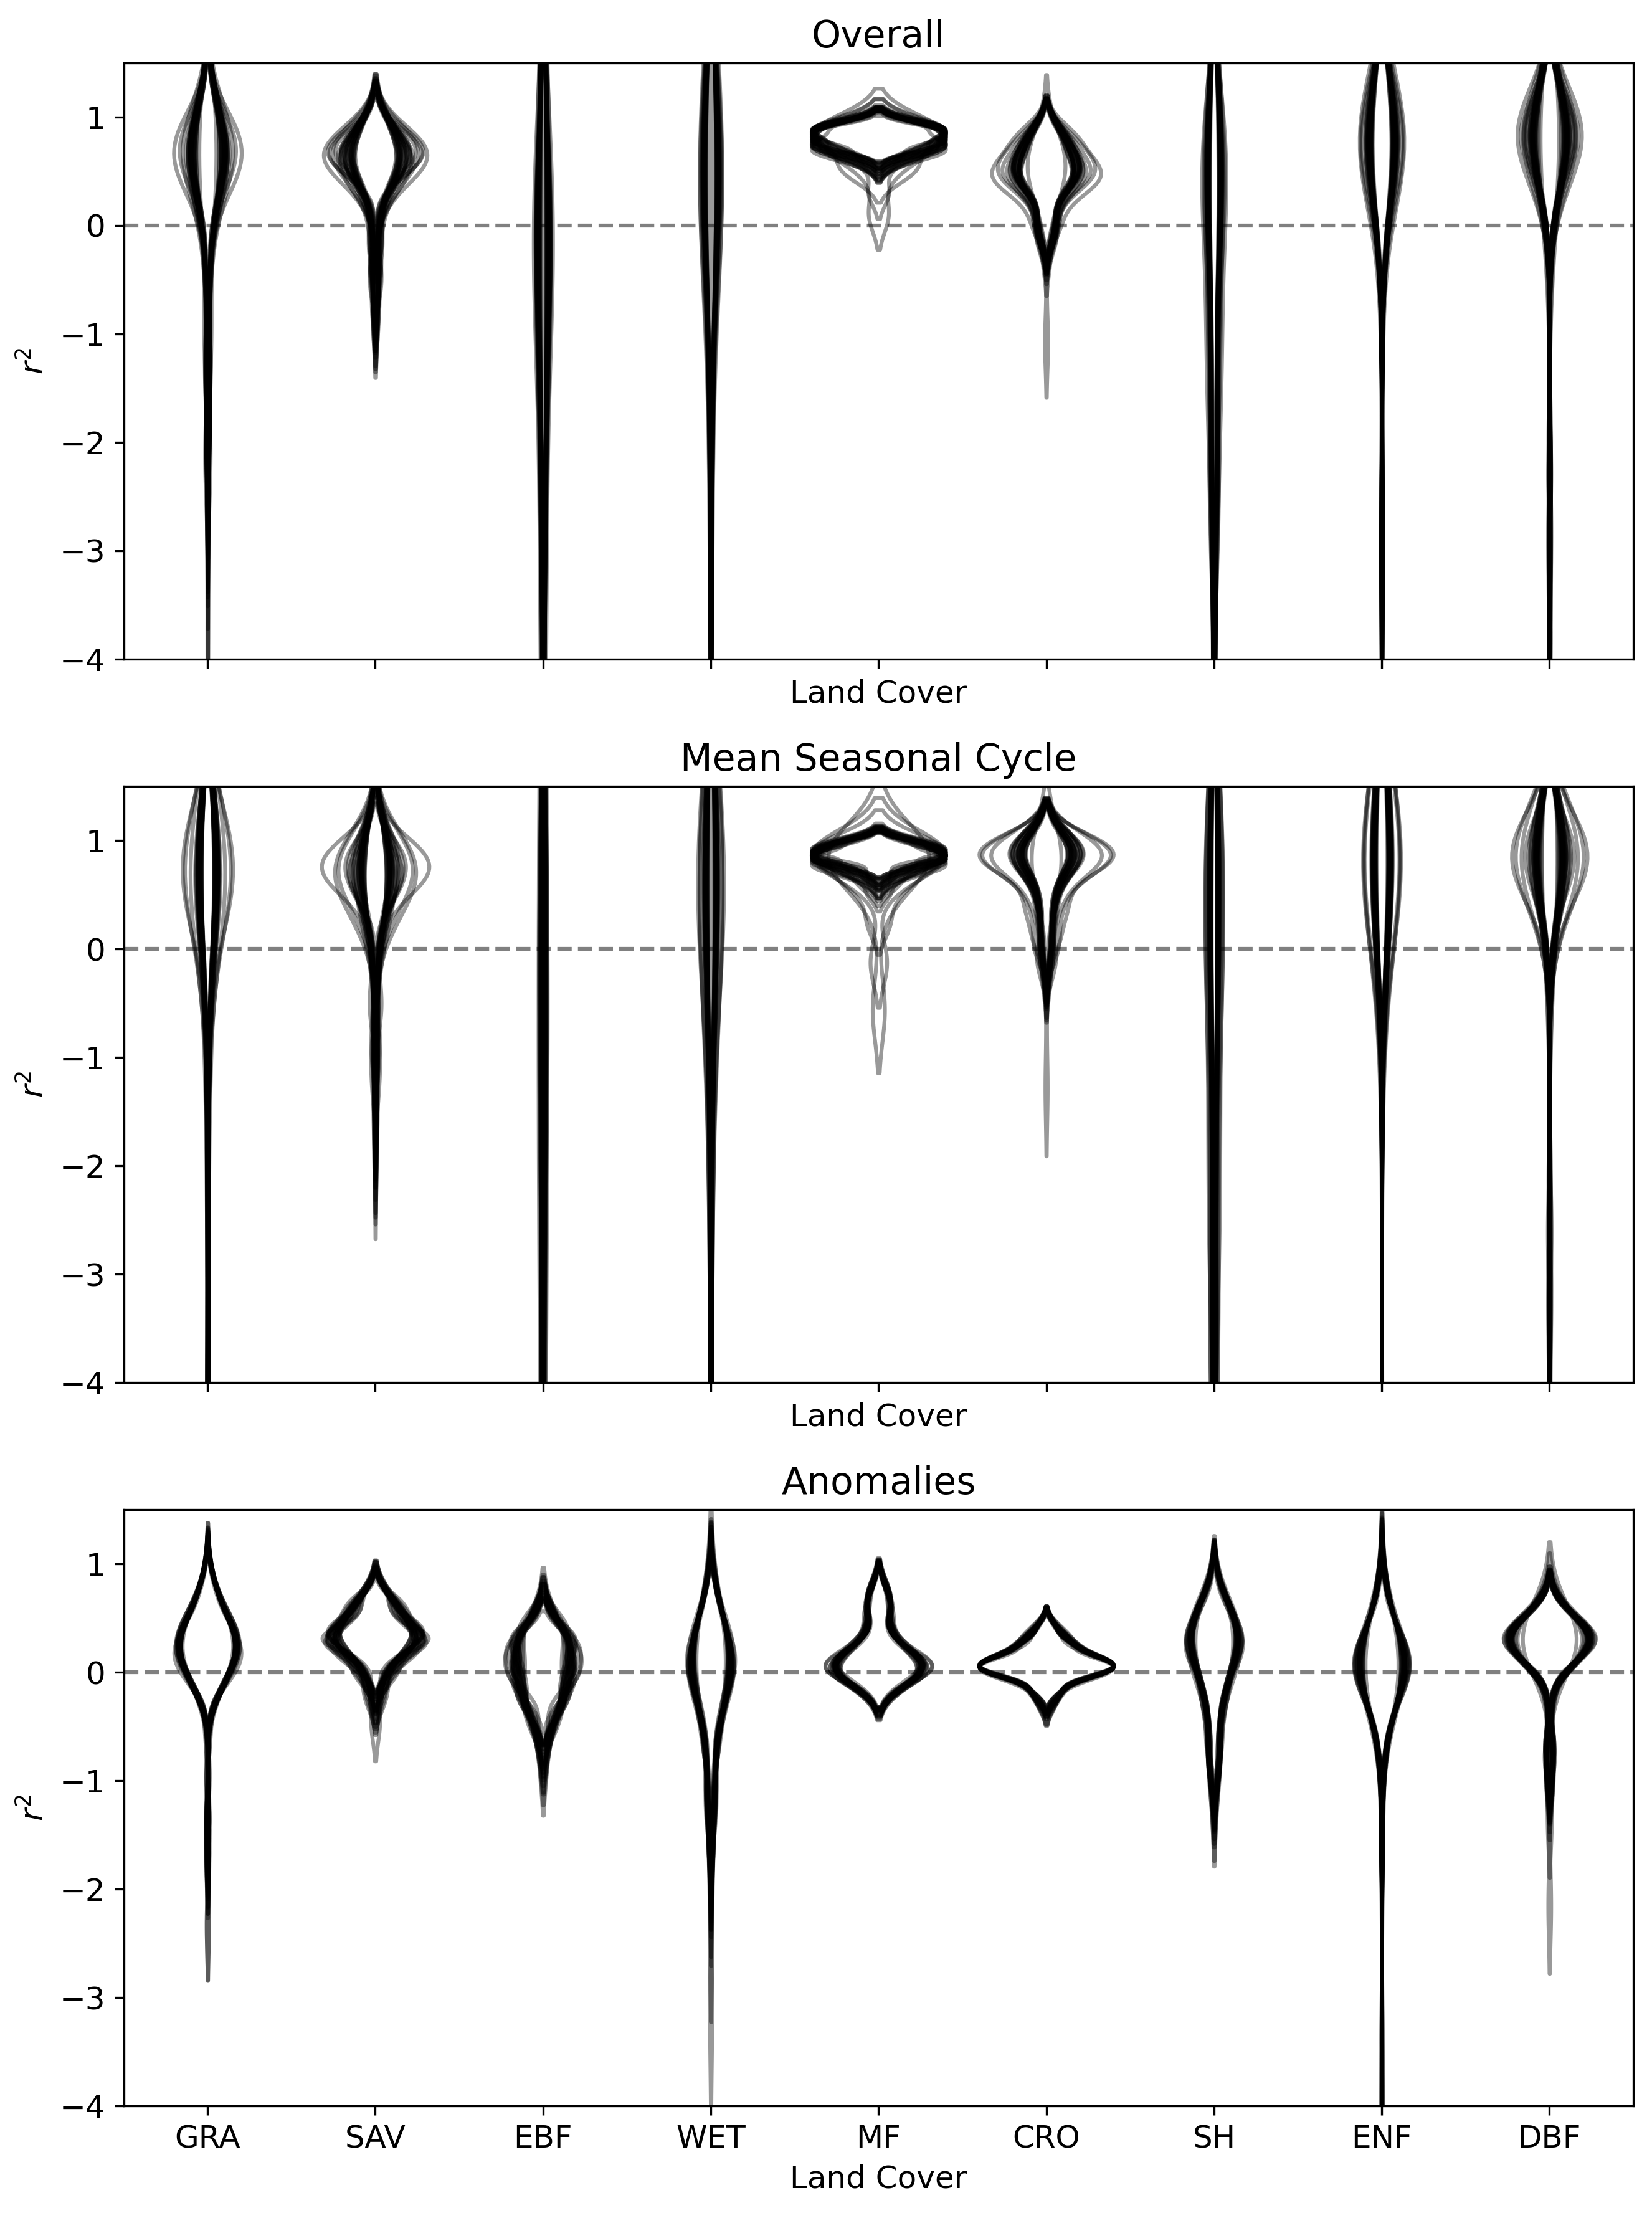

In [18]:
analysis.plt_lc_violin(lc_metrics, 'analysis/benchmark', 'Land Cover', 'exp_id')

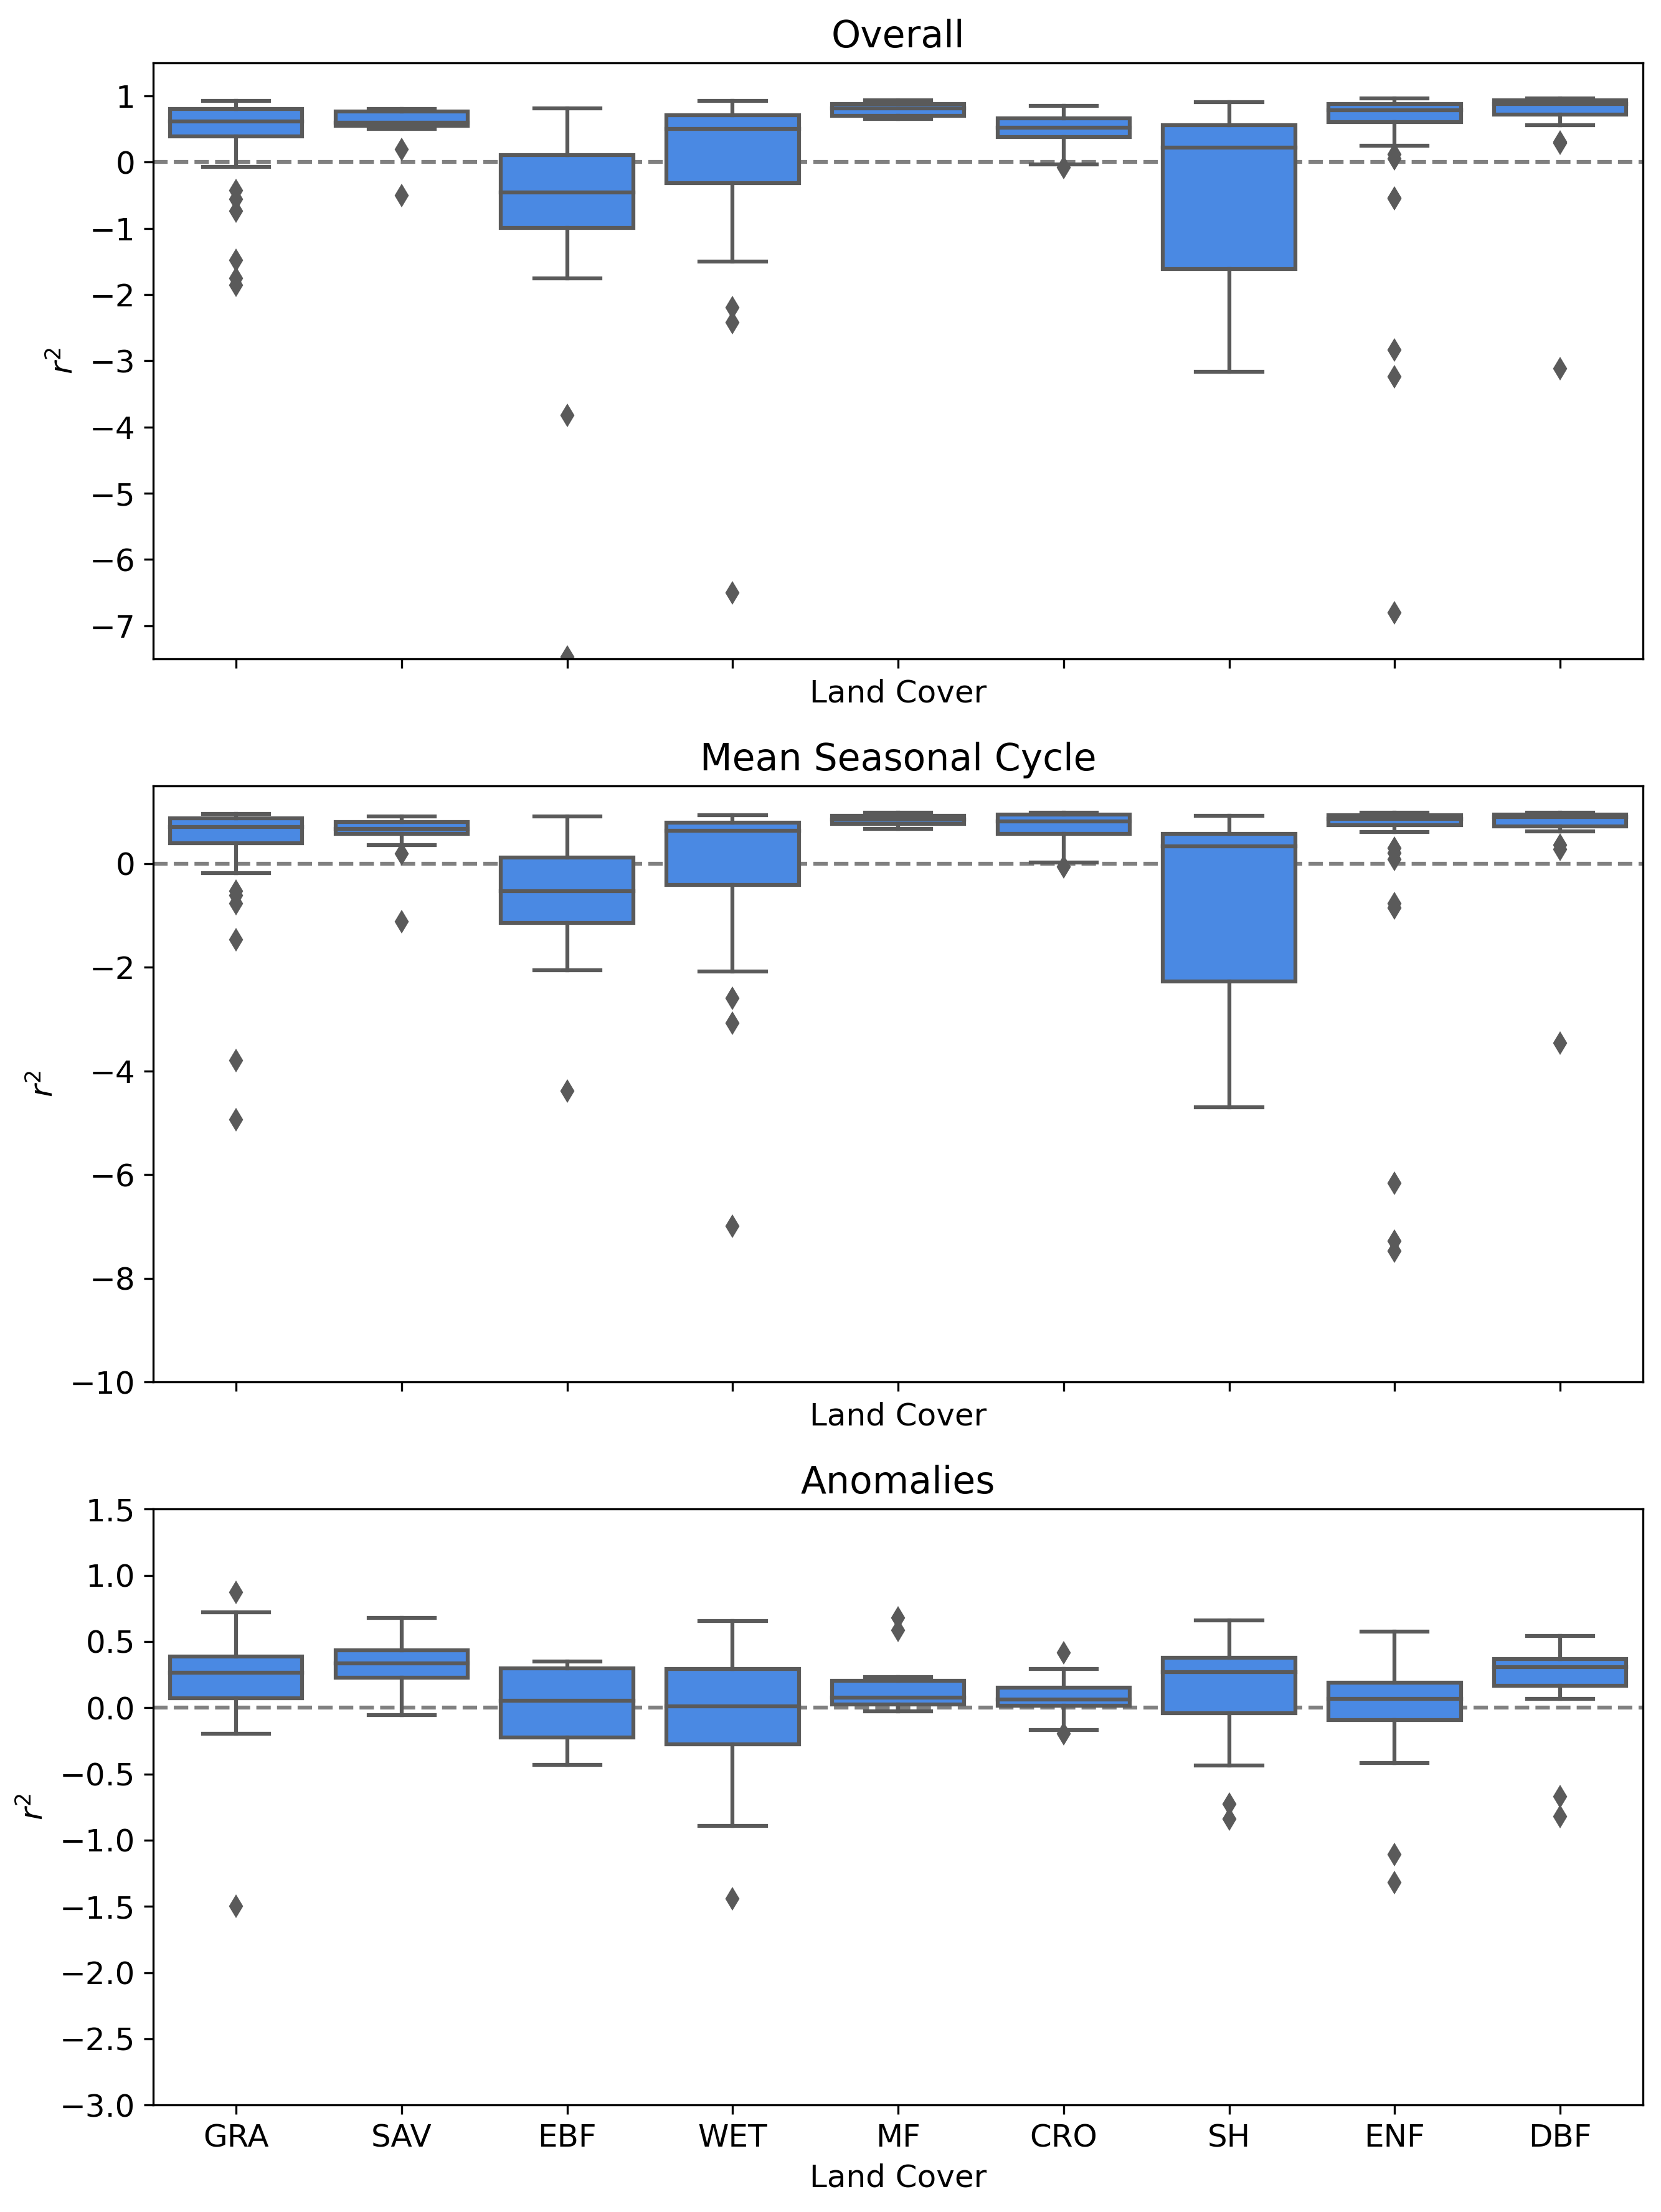

In [19]:
analysis.plt_lc_meanbox(lc_metrics, 'analysis/benchmark', 'Land Cover', 'exp_id')

In [9]:
from importlib import reload
reload(analysis)
reload(utils)

<module 'modules.utils' from '/global/scratch/users/maxgaber/gpp_upscaling/gpp/modules/utils.py'>